# This notebook demonstrates to transform the output of CLUMPY to a template we can use for the HAWC analysis

In [1]:
# import the necessary packages
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt # may not be necessary
import matplotlib.colors as colors
import healpy as hp
from scipy.interpolate import interp2d
import pickle
import os

from matplotlib import rcParams
rcParams['figure.figsize'] = [8.0, 6.0]
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['axes.labelsize'] = 14
rcParams['legend.fontsize'] = 11

In [2]:
# Virgo Cluster coordinates
RA  = 186.75
DEC = 12.3
virgo_coords = SkyCoord(ra=RA*u.degree, dec=DEC*u.degree, frame='fk5')
virgo_lat = virgo_coords.galactic.l.radian
virgo_lon = virgo_coords.galactic.b.radian

filename = "../output/annihil_Virgo2D_FOVdiameter14.0deg_rse5_alphaint0.11deg_nside1024.fits"
hdus     = fits.open(filename)
for i in range(1, len(hdus)):
    print("header {}: {}".format(i, hdus[i].header['EXTNAME']))

header 1: JFACTOR
header 2: JFACTOR_PER_SR
header 3: INTEGRATED_FLUXES


## Read the data from the fits generated with CLUMPY

In [3]:
content = hdus[1].header
theta_0 = content['THETA_0']
psi_0   = content['PSI_0']
size_x  = content['SIZE_X']
size_y  = content['SIZE_Y']
dangle  = content['ALPHAINT']

content = hdus[1].data
pixels  = content['PIXEL']
Jtotal  = content['Jtot']
Jsmooth = content['Jsmooth']
Jsub    = content['Jsub']
Jcross  = content['Jcrossp']
NSIDE    = hdus[2].header['NSIDE']
ordering = hdus[2].header['ORDERING']
if ordering == "NESTED":
    nested = True
else:
    nested = False

nPix = hp.nside2npix(NSIDE)
num_used_pixels = len(pixels)
theta_rad, phi_rad = hp.pixelfunc.pix2ang(NSIDE, pixels, nest=nested)
# change the angles according to our conventions
theta, phi = -np.degrees(theta_rad-np.pi/2.-virgo_lon), np.degrees(np.pi*2.-phi_rad+virgo_lat)
phi[np.where(phi>360)] -= 360.

print("max log10(J)/sr is {}".format(np.log10(Jtotal.max())))

max log10(J)/sr is 21.0312728882


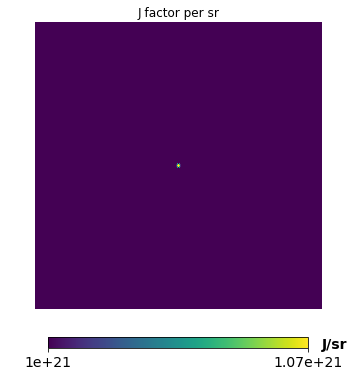

In [4]:
plt.clf()
Jtot = np.ones(nPix)
Jtot[pixels] = Jtotal
hp.cartview(Jtot, latra=[-7., 7.], lonra=[-7., 7.], nest=nested, 
            min=1e21, norm='log', title="J factor per sr", unit="J/sr")
plt.savefig("../original_template.pdf", bbox_inches='tight')
plt.savefig("../original_template.png", bbox_inches='tight')
plt.savefig("../original_template.eps", bbox_inches='tight')
plt.show()

## Process the data for 3ML use

In [5]:
nxPix = 140
nyPix = 140
refX  = 70.5
refY  = 70.5
delX  = -dangle
delY  = dangle
x = np.zeros(nPix)
x[pixels] = Jtotal/np.max(Jtotal)
dmROI = np.zeros([nxPix, nyPix])
for i in range(nxPix):
    for j in range(nyPix):
        ra_roi = (i-np.int(refX))*delX                                                                          
        dec_roi = (j-np.int(refY))*delY
        hpix = hp.pixelfunc.ang2pix(NSIDE,np.radians(-dec_roi+90.),np.radians(360.-ra_roi), nest=nested)
        #print(hpix)
        dmROI[i,j] = x[hpix]

In [6]:
new_hdu = fits.PrimaryHDU(dmROI)
new_hdu.header['CTYPE1'] = 'RA'
new_hdu.header['CTYPE2'] = 'DEC'
new_hdu.header['CUNIT1'] = 'deg'
new_hdu.header['CUNIT2'] = 'deg'
new_hdu.header['CRPIX1'] = refX
new_hdu.header['CRPIX2'] = refY
new_hdu.header['CRVAL1'] = RA
new_hdu.header['CRVAL2'] = DEC
new_hdu.header['CDELT1'] = delX
new_hdu.header['CDELT2'] = delY
hdulist = fits.HDUList([new_hdu])
hdulist.writeto('VirgoCluster_Jfactor_template.fits')

## This section explains how to transform the CLUMPY generated file to a file that can be used in AERIE

In [23]:
if os.path.isfile("interpolator1.pkl"):
    # pickles exist. so only read it and save time
    print("pickles exist... I will read the interpolators from the pickles...")
    interpolator1 = pickle.load(open("interpolator1.pkl", "rb"))
    interpolator2 = pickle.load(open("interpolator2.pkl", "rb"))
else:
    print("pickles are missing... I will run the analysis for interpolators...")
    interpolator1 = interp2d(theta[:25000], phi[:25000], np.log10(Jtotal[:25000]), bounds_error=True)
    interpolator2 = interp2d(theta[25000:], phi[25000:], np.log10(Jtotal[25000:]), bounds_error=True)
    with open('interpolator1.pkl', 'wb') as f:
        pickle.dump(interpolator1, f)
    with open('interpolator2.pkl', 'wb') as f:
        pickle.dump(interpolator2, f)

pickles exist... I will read the interpolators from the pickles...


In [31]:
pixAngle = hp.pix2ang(NSIDE, range(nPix), nest=nested)
lon, lat = -np.degrees(pixAngle[0]-np.pi/2.), np.degrees(np.pi*2.-pixAngle[1])

In [32]:
pix1 = []
j_factors1 = []
for i in range(nPix):
    try:
        j_value  = interpolator1(lon[i], lat[i])[0]
        if j_value > 26:
            continue
        pix1.append(i)
        j_factors1.append(j_value)
    except:
        continue
    
pix2 = []
j_factors2= []
for i in range(nPix):
    try:
        j_value  = interpolator2(lon[i], lat[i])[0]
        if j_value > 26:
            continue
        pix2.append(i)
        j_factors2.append(j_value)
    except:
        continue

Jtot = np.zeros(nPix)
Jtot[pix1] = j_factors1
Jtot[pix2] = j_factors2

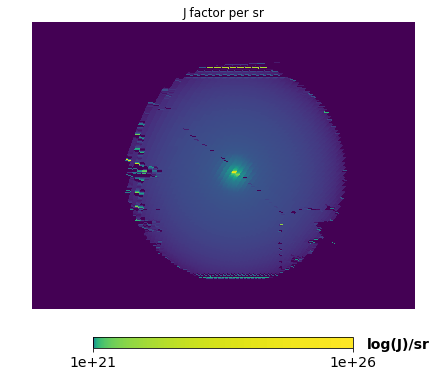

In [114]:
Jtot = np.zeros(nPix)
Jtot[pix1] = j_factors1
for i in range(len(pix2)):
    if Jtot[pix2[i]] < 20:
        Jtot[pix2[i]] = j_factors2[i]
plt.clf()
Jtot[np.where(Jtot<=21)] = 0
Jtot[np.where(Jtot>=26)] = 0
Jtot = 10**Jtot
hp.cartview(Jtot, latra=[67., 82.], lonra=[70., 90.], nest=nested, min=1e21, max=1e26,
           title="J factor per sr", unit="log(J)/sr", norm='log')
plt.savefig("../translated_template.pdf", bbox_inches='tight')
plt.savefig("../translated_template.png", bbox_inches='tight')
plt.savefig("../translated_template.eps", bbox_inches='tight')
plt.show()
Jtot = Jtot/np.max(Jtot)

In [146]:
new_hdu = fits.PrimaryHDU(Jtot)
new_hdu.header['CTYPE1'] = 'RA'
new_hdu.header['CTYPE2'] = 'DEC'
new_hdu.header['CUNIT1'] = 'deg'
new_hdu.header['CUNIT2'] = 'deg'
new_hdu.header['CRPIX1'] = 70.5
new_hdu.header['CRPIX2'] = 70.5
new_hdu.header['CRVAL1'] = RA
new_hdu.header['CRVAL2'] = DEC
new_hdu.header['CDELT1'] = -dangle
new_hdu.header['CDELT2'] = dangle
hdulist = fits.HDUList([new_hdu])
hdulist.writeto('VirgoCluster_Jfactor_template.fits')

In [201]:
x = fits.open("VirgoCluster_Jfactor_template.fits")

In [132]:
from astropy import wcs
from astropy.coordinates import SkyCoord, ICRS, BaseCoordinateFrame

In [202]:
_wcs = wcs.WCS(header=x[0].header)
_nX = x[0].header['NAXIS1']
_nY = x[0].header['NAXIS2']
_map = x[0].data

In [189]:
xcorners = np.array( [0, 0, _nX, _nX] )
ycorners = np.array( [0, _nY, 0, _nY] )
SkyCoord.from_pixel( xcorners, ycorners, wcs=_wcs, origin = 0, mode='wcs')

<SkyCoord (ICRS): (ra, dec) in deg
    [( 194.7425,   4.3075), ( 194.7425,  20.4075), ( 178.6425,   4.3075),
     ( 178.6425,  20.4075)]>

In [203]:
np.max(_map)

0.99995779991149902

In [192]:
_map[_map>0.]

array([], dtype=float64)